# Wall of imports

In [1]:
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

import itertools

import pandas as pd

import numpy as np

import copy

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import PCA

import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline
%matplotlib widget

from tqdm import tqdm

from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import Normalizer

RANDOM_SEED = None

from pyspark.ml.evaluation import ClusteringEvaluator

from pyspark.ml.linalg import Vectors

from functools import reduce

import json

from pyspark.ml.regression import LinearRegression

from pyspark_dist_explore import hist

from pyspark.ml.regression import RandomForestRegressor

from pyspark.ml.regression import DecisionTreeRegressor

from pyspark.ml import Pipeline

from pyspark.ml.tuning import ParamGridBuilder

from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.ml.regression import GBTRegressor

from pyspark.ml.classification import MultilayerPerceptronClassifier

from pyspark.ml.classification import LogisticRegression

from pyspark.ml.classification import LinearSVC, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier

from operator import itemgetter

from pyspark.ml.feature import MinMaxScaler

from pyspark.ml.linalg import Vectors, VectorUDT

from pyspark.ml.stat import Summarizer

from sklearn.manifold import TSNE

from sklearn.decomposition import KernelPCA

from pyspark.ml.feature import UnivariateFeatureSelector
from pyspark.ml.linalg import DenseVector
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import re

import sklearn
from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
# from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import cross_val_score

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
# from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import FunctionTransformer


import warnings # supress warnings
warnings.filterwarnings('ignore')

# Spark

In [2]:
conf = (
    SparkConf()
    .set("spark.ui.port", "4050")
    .set("spark.executor.memory", "4G")
    .set("spark.driver.memory", "20G")
    .set("spark.driver.maxResultSize", "10G")
)
# .set("spark.master", "spark://192.168.1.189:4050")


# create the context
sc = SparkContext(conf=conf)
sc.setLogLevel("ERROR")


spark = SparkSession.builder.getOrCreate()

22/06/16 11:20:38 WARN Utils: Your hostname, macchinario resolves to a loopback address: 127.0.1.1; using 192.168.1.12 instead (on interface enp0s31f6)
22/06/16 11:20:38 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/06/16 11:20:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Loading football players

In [3]:
modern_df = spark.read.csv(
    "data/players_*.csv", sep=",", inferSchema=True, header=True, multiLine=True
)

legacy_df = spark.read.csv(
    "data/scraped_players_*.csv", sep=",", inferSchema=True, header=True, 
    multiLine=True
)

# Pre-processing football players

In [4]:
leagues = [
    "Spain Primera Division",
    # "German 1. Bundesliga",
    # "French Ligue 1",
    # "English Premier League",
    # "Italian Serie A",
    # "Holland Eredivisie",
]

# seasons_modern = ["20", "19", "18", "17", "16", "15", "14"] 
seasons_modern = ["20", "19"] 
# seasons_legacy = ["13", "12", "11", "10", "09", "08", "07"]
seasons_legacy = [ ]
seasons = seasons_legacy + seasons_modern

# football_teams = [
#     row["club_name"] for row in modern_df.select(
#         "club_name"
#     ).distinct().collect()
# ]

macro_roles = ["0.0", "1.0", "2.0", "3.0", "4.0", "5.0", "6.0", "7.0"]

roles_to_macro_roles_dict = {
    "GK": "0",
    "LB": "1",
    "RB": "1",
    "RWB": "1",
    "LWB": "1",
    "CB": "2",
    "CDM": "3",
    "CM": "4",
    "RM": "4",
    "LM": "4",
    "CAM": "5",
    "RW": "6",
    "LW": "6",
    "ST": "7",
    "LF": "7",
    "RF": "7",
    "CF": "7",
}
NUM_MACRO_ROLES = 8

columns = [
    "short_name",
    "club_name",
    "league_name",
    "season",
    "player_positions",
    "macro_role",
    "overall",
    "value",
    "pace",
    "shooting",
    "passing",
    "dribbling",
    "defending",
    "physic",
    "attacking_crossing",
    "attacking_finishing",
    "attacking_heading_accuracy",
    "attacking_short_passing",
    "skill_dribbling",
    "skill_fk_accuracy",
    "skill_long_passing",
    "skill_ball_control",
    "movement_acceleration",
    "movement_sprint_speed",
    "movement_reactions",
    "power_shot_power",
    "power_stamina",
    "power_strength",
    "power_long_shots",
    "mentality_aggression",
    "mentality_penalties",
    "defending_standing_tackle"
]

def get_season(url):
    url_split = url.split("/")

    # -1 to scale FIFA years down, to have compatibility with all_tables_fixed
    return str(
        (int(url_split[-2 if url_split[-1] == "" else -1][0:2]) - 1)
    ).zfill(2)


get_season_UDF = udf(lambda url: get_season(url), StringType())

roles_to_macro_role_UDF = udf(
    lambda roles: float(roles_to_macro_roles_dict[roles.split(",")[0]]), StringType()
)

In [5]:
pre_processed_modern_df = modern_df.dropDuplicates(["player_url"])
pre_processed_legacy_df = legacy_df.dropDuplicates(["player_url"])

pre_processed_modern_df = pre_processed_modern_df.na.fill(0)
pre_processed_legacy_df = pre_processed_legacy_df.na.fill(0)

pre_processed_modern_df = pre_processed_modern_df.withColumn(
    "season", get_season_UDF(col("player_url"))
)
pre_processed_legacy_df = pre_processed_legacy_df.withColumn(
    "season", get_season_UDF(col("player_url"))
)

pre_processed_modern_df = pre_processed_modern_df.withColumn(
    "macro_role", roles_to_macro_role_UDF(col("player_positions"))
)
pre_processed_legacy_df = pre_processed_legacy_df.withColumn(
    "macro_role", roles_to_macro_role_UDF(col("player_positions"))
)

pre_processed_modern_df = pre_processed_modern_df.withColumnRenamed(
    "value_eur", "value"
)

pre_processed_modern_df = pre_processed_modern_df.where(
    (pre_processed_modern_df.league_name.isin(leagues))
    &
    (pre_processed_modern_df.season.isin(seasons_modern))
)
pre_processed_legacy_df = pre_processed_legacy_df.where(
    (pre_processed_legacy_df.league_name.isin(leagues))
    &
    (pre_processed_legacy_df.season.isin(seasons_legacy))
)

pre_processed_modern_df = pre_processed_modern_df.select(columns)

# TODO use a for loop
pre_processed_legacy_df = pre_processed_legacy_df.withColumnRenamed(
    "pas", "passing"
)
pre_processed_legacy_df = pre_processed_legacy_df.withColumnRenamed(
    "dri", "dribbling"
)
pre_processed_legacy_df = pre_processed_legacy_df.drop(col("defending"))

pre_processed_legacy_df = pre_processed_legacy_df.withColumnRenamed(
    "def", "defending"
)
pre_processed_legacy_df = pre_processed_legacy_df.withColumnRenamed(
    "phy", "physic"
)

pre_processed_legacy_df = pre_processed_legacy_df.withColumnRenamed(
    "sho", "shooting"
)
pre_processed_legacy_df = pre_processed_legacy_df.withColumnRenamed(
    "pac", "pace"
)
pre_processed_legacy_df = pre_processed_legacy_df.withColumnRenamed(
    "bov", "overall"
)

pre_processed_legacy_df = pre_processed_legacy_df.select(columns)

In [6]:
pre_processed_df = pre_processed_modern_df.unionByName(
    pre_processed_legacy_df
)


# Building football teams

In [7]:
football_teams_df = pre_processed_df

In [8]:
PLAYER_FEATURES = [
    "overall",
    "value",
    "pace",
    "shooting",
    "passing",
    "dribbling",
    "defending",
    "physic",
    "attacking_crossing",
    "attacking_finishing",
    "attacking_heading_accuracy",
    "attacking_short_passing",
    "skill_dribbling",
    "skill_fk_accuracy",
    "skill_long_passing",
    "skill_ball_control",
    "movement_acceleration",
    "movement_sprint_speed",
    "movement_reactions",
    "power_shot_power",
    "power_stamina",
    "power_strength",
    "power_long_shots",
    "mentality_aggression",
    "mentality_penalties",
    "defending_standing_tackle"
]

PLAYER_FEATURES_AVG = [
    "avg(" + player_feature + ")" for player_feature in PLAYER_FEATURES
]

TARGET_VARIABLE = "points"

In [9]:
football_teams_df = football_teams_df.select(
    "season", "club_name", *PLAYER_FEATURES
).groupBy(
    ["season", "club_name"]
).agg(
    { player_feature: "avg" for player_feature in PLAYER_FEATURES }
)

# Loading football teams seasonal scores

In [10]:
seasonal_scores_df = (
    spark.read.csv(
        "data/all_tables_fixed_renamed_leagues.csv",
        sep=",",
        inferSchema=True,
        header=True,
        multiLine=True,
    )
    .withColumnRenamed("Year", "season")
    .withColumnRenamed("Team", "club_name_abbr")
    .withColumnRenamed("P", "points")
    .withColumnRenamed("Place", "place")
    .withColumnRenamed("League", "league")
)

# Pre-processing football teams seasonal scores

In [11]:
seasonal_scores_columns = [
    "season", "club_name_abbr", "points", "place", "league"
]

f = open("data/clubs_map.json")
club_name_abbr_to_ext = json.load(f)
f.close()

abbreviate_season_UDF = udf(
    lambda season: str(season)[-2:],
    StringType(),
)

def extend_club_name(club_name_abbr):
    try:
        return club_name_abbr_to_ext[club_name_abbr]
    except KeyError as e:
        return "NOT_FOUND"
    except Exception as e:
        return "GENERAL_EXCEPTION"

extend_club_name_UDF = udf(
    lambda club_name_abbr: extend_club_name(str(club_name_abbr)),
    StringType(),
)

In [12]:
pre_processed_seasonal_scores_df = seasonal_scores_df

pre_processed_seasonal_scores_df = pre_processed_seasonal_scores_df.dropDuplicates(
    seasonal_scores_columns
)

pre_processed_seasonal_scores_df = pre_processed_seasonal_scores_df.na.fill(0)

pre_processed_seasonal_scores_df = pre_processed_seasonal_scores_df.select(
    seasonal_scores_columns
)

pre_processed_seasonal_scores_df = pre_processed_seasonal_scores_df.withColumn(
    "season", abbreviate_season_UDF(col("season"))
)

pre_processed_seasonal_scores_df = pre_processed_seasonal_scores_df.withColumn(
    "club_name", extend_club_name_UDF(col("club_name_abbr"))
)

pre_processed_seasonal_scores_df = pre_processed_seasonal_scores_df.withColumn(
    "points", pre_processed_seasonal_scores_df.points.cast(DoubleType())
)

if pre_processed_seasonal_scores_df.filter(
    col("club_name") == "NOT_FOUND"
).count() > 0:
    print("WARN: some clubs have NOT been found")
    print("Please check your data")

WARN: some clubs have NOT been found
Please check your data


In [13]:
pre_processed_seasonal_scores_df = pre_processed_seasonal_scores_df.where(
    (pre_processed_seasonal_scores_df.season.isin(seasons))
    & (pre_processed_seasonal_scores_df.league.isin(leagues))
)

In [14]:
seasonal_scores_pre_join_columns = [
    # "year", "league", "club_name_ext", "points", "place"
    "season", "league", "club_name", "points", "place"
]

pre_processed_seasonal_scores_df = pre_processed_seasonal_scores_df.select(
    seasonal_scores_pre_join_columns
)

# Joining football teams features with their seasonal scores

In [15]:
# df = football_teams_df.join(
#     pre_processed_seasonal_scores_df,
#     (football_teams_df.season == pre_processed_seasonal_scores_df.year)
#     & (
#         football_teams_df.club_name
#         == pre_processed_seasonal_scores_df.club_name_ext
#     ),
# )
df = football_teams_df.join(
    pre_processed_seasonal_scores_df,
    on = ["season", "club_name"],
)

In [16]:
# if pre_processed_seasonal_scores_df.select("club_name_ext").distinct().subtract(
if pre_processed_seasonal_scores_df.select("club_name").distinct().subtract(
    # df.select("club_name_ext").distinct()
    df.select("club_name").distinct()
).count() > 0:
    print("WARN: Some football teams have been left out the join (pre_processed_seasonal_scores_df)")
    print("Please, check your data!")

if football_teams_df.select("club_name").distinct().subtract(
    # df.select("club_name_ext").distinct()
    df.select("club_name").distinct()
).count() > 0:
    print("WARN: Some football teams have been left out the join (football_teams_df)")
    print("Please, check your data!")

# Attempt 1: "naive" player features

Naive --> simply take the given features and NOT crafting them from other learning processes (i.e. NO clustering or stuff)

In [ ]:
ALL_FEATURES = PLAYER_FEATURES_AVG
ALL_FEATURES.remove("avg(overall)")
ALL_FEATURES.remove("avg(value)")


In [ ]:
assembler = VectorAssembler(
    inputCols=ALL_FEATURES, outputCol="all_vec"
)

df = assembler.transform(df)

In [ ]:
def plot_feature_target_relation(
    data, x, y, n_rows = 12, n_cols = 2, figsize = (20, 40), color = "#000000"
):

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)

    for x_ind, x_value in enumerate(x):
        ax = sns.regplot(
            data=pdf,
            x=x_value,
            y=y,
            color = color,
            ax=axes[x_ind // n_cols, x_ind % n_cols],
        )


    fig.tight_layout(pad=1.5)

In [ ]:
def plot_feature_distribution(
    data, features, figsize = (20, 40), 
    color = "#000000"
):

    n_cols = 2
    n_rows = int(len(features) / n_cols) if len(features) >= n_cols else n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 30))

    for feature_ind, feature in enumerate(features):
        _ = sns.histplot(
            data[feature],
            kde=True,
            color=color,
            facecolor=color,
            ax=axes[feature_ind // n_cols, feature_ind % n_cols],
        )

    fig.tight_layout(pad=1.5)

In [ ]:
def plot_correlation_matrix(
    data, features, title = "Pearson Correlation Matrix", figsize = (16,12)
):

    mask = np.zeros_like(data[features].corr(), dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    with sns.axes_style("white"):  # Temporarily set the background to white
        fig, ax = plt.subplots(figsize=figsize)
        plt.title(title, fontsize=24)

        cmap = sns.diverging_palette(220, 10, as_cmap=True)

        _ = sns.heatmap(
            data[features].corr(),
            linewidths=0.25,
            vmax=0.7,
            square=True,
            ax=ax,
            cmap=cmap,
            linecolor="w",
            annot=True,
            annot_kws={"size": 8},
            mask=mask,
            cbar_kws={"shrink": 0.9},
        )

## Raw data

*[explain what does "raw" mean]*

In [ ]:
COLOR_RAW = "#332FD0"

In [ ]:
pdf = df.toPandas()

### Feature-target correlation

In [ ]:
#TODO set an appropriate figsize for Google Colab
plot_feature_target_relation(
    pdf, ALL_FEATURES, TARGET_VARIABLE, figsize=(4,4), color=COLOR_RAW
)

### Feature distribution

In [ ]:
plot_feature_distribution(pdf, ALL_FEATURES, color = COLOR_RAW, figsize=(4,4))

### Pearson Correlation Matrix

In [ ]:
plot_correlation_matrix(pdf, ALL_FEATURES)

## Standardization

Since we have some features with skewed distributions, we'll try to standardize, to see whether it helps with feature skewness or not

In [ ]:
# standardized_df = df

In [ ]:
scaler = StandardScaler(
    inputCol="all_vec", 
    outputCol="all_vec_std", 
    withStd=True, 
    withMean=True
)

In [ ]:
# standardized_df = scaler.fit(standardized_df).transform(standardized_df)
df = scaler.fit(df).transform(df)

In [ ]:
COLOR_STD = "#9254C8"

ALL_FEATURES_STD = [
    player_feature + "_std" for player_feature in ALL_FEATURES
]

In [ ]:
# pdf = standardized_df.toPandas()
pdf = df.toPandas()

In [ ]:
#TODO make a commodity function, because it will be used in other normalizations as well

pdf = pdf.reindex(
    columns=list(pdf.columns) + ALL_FEATURES_STD
)

pdf[ALL_FEATURES_STD] = pdf[
    "all_vec_std"
].transform(
    {
        ALL_FEATURES_STD[i]: itemgetter(i) for i, p in enumerate(ALL_FEATURES_STD)
    }

    
)

### Feature-target correlation

In [ ]:
#TODO set an appropriate figsize for Google Colab
plot_feature_target_relation(
    pdf, ALL_FEATURES_STD, TARGET_VARIABLE, figsize=(4,4), color=COLOR_STD
)

#### Feature distribution

In [ ]:
plot_feature_distribution(
    pdf, ALL_FEATURES_STD, color = COLOR_STD, figsize=(10,10)
)

*[state why pearson correlation matrix does NOT make sense to be plotted again]*

## Log transformation

In [ ]:
# log_df = df

In [ ]:
ALL_FEATURES_LOG = [
    player_feature + "_log" for player_feature in ALL_FEATURES
]

COLOR_LOG = "#E15FED"

In [ ]:
to_log_UDF = udf(
    lambda value: float(np.log2(value)), DoubleType()
)

In [ ]:
for f, fl in zip(ALL_FEATURES, ALL_FEATURES_LOG):
    # log_df = log_df.withColumn(fl, to_log_UDF(col(f)))
    df = df.withColumn(fl, to_log_UDF(col(f)))

In [ ]:
# pdf = log_df.toPandas()
pdf = df.toPandas()

### Feature-target correlation

In [ ]:
#TODO set an appropriate figsize for Google Colab
plot_feature_target_relation(
    pdf, ALL_FEATURES_LOG, TARGET_VARIABLE, figsize=(4,4), color=COLOR_LOG
)

### Feature distribution

In [ ]:
plot_feature_distribution(pdf, ALL_FEATURES_LOG, color = COLOR_LOG, figsize=(10,10))

## Min-max transformation

In [ ]:
# min_max_df = df

In [ ]:
ALL_FEATURES_MIN_MAX = [
    player_feature + "_min_max" for player_feature in ALL_FEATURES
]

COLOR_MIN_MAX = "#6EDCD9"

In [ ]:
scaler = MinMaxScaler(
    inputCol="all_vec", 
    outputCol="all_vec_min_max"
)

In [ ]:
# min_max_df = scaler.fit(min_max_df).transform(min_max_df)
df = scaler.fit(df).transform(df)

In [ ]:
# pdf = min_max_df.toPandas()
pdf = df.toPandas()

In [ ]:
#TODO make a commodity function, because it will be used in other normalizations as well

pdf = pdf.reindex(
    columns=list(pdf.columns) + ALL_FEATURES_MIN_MAX
)

pdf[ALL_FEATURES_MIN_MAX] = pdf[
    "all_vec_min_max"
].transform(
    {
        ALL_FEATURES_MIN_MAX[i]: itemgetter(i) for i, p in enumerate(ALL_FEATURES_MIN_MAX)
    }
)

### Feature-target relationship

In [ ]:
#TODO set an appropriate figsize for Google Colab
plot_feature_target_relation(
    pdf, ALL_FEATURES_MIN_MAX, TARGET_VARIABLE, figsize=(4,4), color=COLOR_MIN_MAX
)

### Feature distribution

In [ ]:
plot_feature_distribution(pdf, ALL_FEATURES_MIN_MAX, color = COLOR_MIN_MAX, figsize=(10,10))

In [ ]:
#TODO place learning on ## titles here

# Attempt 2: "less is more"

Ok, considering all features gives trash results.

What if we embrace the "less is more idea" and try to improve the results by means of using less features?

Nevertheless, feature correlation is very high, so, intrinsicly, it already did NOT make much sense to consider them all.

## PCA (on min-max normalized data)

In [ ]:
# pca_df = min_max_df
# pca_df = df

PCA_NUM_COMPONENTS = 5
PCA_NUM_COMPONENTS_TO_PLOT = 2

pca = PCA(
    k=PCA_NUM_COMPONENTS, 
    inputCol="all_vec_min_max", 
    outputCol="all_vec_min_max_pcs"
)

# pca_model = pca.fit(pca_df)
# pca_df = pca_model.transform(pca_df)
pca_model = pca.fit(df)
df = pca_model.transform(df)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
_ = sns.barplot(
    x=[i for i in range(PCA_NUM_COMPONENTS_TO_PLOT)],
    y=pca_model.explainedVariance.values[0:PCA_NUM_COMPONENTS_TO_PLOT],
    ax=ax,
)

_ = ax.set_xlabel("Eigenvalues", labelpad=16, fontsize=16)
_ = ax.set_ylabel("Proportion of Variance", fontsize=16)
_ = ax.set_xticklabels(
    [f"Principal Component {i}" for i in range(PCA_NUM_COMPONENTS_TO_PLOT)], 
    rotation=0
)
_ = ax.set_title("Explained variance of each Principal Component")

In [ ]:
def scatter_plot(data, x, y, c, x_label, y_label):

    fig, ax = plt.subplots(1, 1, figsize=(12, 8))

    _ = plt.scatter(
        x = x,
        y = y,
        c = c,
        edgecolor="none",
        alpha=1,
        cmap="rainbow",
        axes=ax
    )

    _ = ax.set_xlabel(x_label, labelpad=20, fontsize=16)
    _ = ax.set_ylabel(y_label, fontsize=16)

    plt.colorbar()
    plt.show()

In [ ]:
# pca_pdf = pca_df.toPandas()
pca_pdf = df.toPandas()

In [ ]:
scatter_plot(
    pca_pdf, 
    pca_pdf.all_vec_min_max_pcs.map(lambda x: x[0]),
    pca_pdf.all_vec_min_max_pcs.map(lambda x: x[1]),
    pca_pdf.points,
    "Principal Component 0",
    "Principal Component 1"
)

In [ ]:
# TODO evaluate whether points should be normlized to same scale as PCA values
scatter_plot(
    pca_pdf, 
    pca_pdf.all_vec_min_max_pcs.map(lambda x: x[0]),
    pca_pdf.points,
    pca_pdf.points,
    "Principal Component 0",
    "Points"
)

In [ ]:
# TODO evaluate whether points should be normlized to same scale as PCA values
scatter_plot(
    pca_pdf, 
    pca_pdf.all_vec_min_max_pcs.map(lambda x: x[1]),
    pca_pdf.points,
    pca_pdf.points,
    "Principal Component 1",
    "Points"
)

### Feature-target relationship

### Feature distribution

*[bridge between this and Feature selection]*

## Chi-squared

## TNSE

## Univariate Feature Selection

Log scaling reduces skewedness of "avg(mentality_penalties)" feature BUT it increases the skewedness of all the other features.
The other scalings (z-score and min-max) do NOT appear to be different than the "raw" data distribution.

For this reason and due to the limited amount of resources available on Google Colab, we decided to stick with the min-max scaled data.
In fact, the min-max scaling places "for free" all the features in the same scale, which is a very important consideration for SVM, which will be used in the upcoming sections

In [ ]:
# feature_selection_df = min_max_df

In [ ]:
selector = UnivariateFeatureSelector(
    featuresCol="all_vec",
    labelCol=TARGET_VARIABLE, 
    selectionMode="percentile"
).setFeatureType("continuous").setLabelType("categorical").setSelectionThreshold(0.08)

In [ ]:
NUM_FEATURES = 2

In [ ]:
fit_result = dict()

# for thr in range(0.1, 1.1, 0.1):
# for thr in np.linspace(1, 1, 1):
for thr in [0.1]:

    selector.setSelectionThreshold(thr)
    selector.setOutputCol("ufs_" + str(thr).replace(".", "-")),
    fit_result[str(thr)] = selector.fit(df)
    # feature_selection_df = fit_result[str(thr)].transform(
    #     feature_selection_df
    # )
    df = fit_result[str(thr)].transform(df)


In [ ]:
# feature_selection_pdf = feature_selection_df.toPandas()
feature_selection_pdf = df.toPandas()

In [ ]:
scatter_plot(
    feature_selection_pdf,
    feature_selection_pdf["ufs_0-1"].map(lambda x: x[0]),
    feature_selection_pdf["ufs_0-1"].map(lambda x: x[1]),
    feature_selection_pdf.points,
    "Feature 0",
    "Feature 1"
    
)

In [ ]:
scatter_plot(
    feature_selection_pdf,
    feature_selection_pdf["ufs_0-1"].map(lambda x: x[0]),
    feature_selection_pdf.points,
    feature_selection_pdf.points,
    "Feature 0",
    "Points"
    
)

In [ ]:
scatter_plot(
    feature_selection_pdf,
    feature_selection_pdf["ufs_0-1"].map(lambda x: x[1]),
    feature_selection_pdf.points,
    feature_selection_pdf.points,
    "Feature 1",
    "Points"
    
)

In [ ]:
pdf = df.toPandas()

In [ ]:
selected_features = list(
    map(
        lambda i: ALL_FEATURES[i], fit_result["0.1"].selectedFeatures
    )
)

### Feature-target relationship

In [ ]:
#TODO set an appropriate figsize for Google Colab
plot_feature_target_relation(
    pdf, selected_features, TARGET_VARIABLE, figsize=(4,4), 
    color=COLOR_MIN_MAX
)

### Feature correlation

look at it from the original pearson matrix

state that these data distribs are trash.

So, for this reason, talk about overall and value.

## Overall as feature (min-max normalized)

Since the features are so correlated and performances of attempt 1 are trash, why not considering just the overall as a feature?

Maybe, we're lucky and the overall captures some other characteristics thay may steer the prediction a little bit more

In [ ]:
OVERALL = ["avg(overall)"]

COLOR_OVERALL_MIN_MAX = "green"

In [ ]:
assembler = VectorAssembler(
    inputCols=OVERALL, outputCol="overall_vec"
)

# min_max_df = assembler.transform(min_max_df)
df = assembler.transform(df)

In [ ]:
OVERALL_MIN_MAX = ["avg(overall)_min_max"]

In [ ]:
scaler = MinMaxScaler(
    inputCol="overall_vec", 
    outputCol="overall_vec_min_max"
)

In [ ]:
# min_max_df = scaler.fit(min_max_df).transform(min_max_df)
df = scaler.fit(df).transform(df)

In [ ]:
# pdf = min_max_df.toPandas()
pdf = df.toPandas()

In [ ]:
#TODO make a commodity function, because it will be used in other normalizations as well

pdf = pdf.reindex(
    columns=list(pdf.columns) + OVERALL_MIN_MAX
)

pdf[OVERALL_MIN_MAX] = pdf[
    "overall_vec_min_max"
].transform(
    {
        OVERALL_MIN_MAX[i]: itemgetter(i) for i, p in enumerate(OVERALL_MIN_MAX)
    }
)

### Feature-target relationship

In [ ]:
#TODO set an appropriate figsize for Google Colab
plot_feature_target_relation(
    pdf, OVERALL_MIN_MAX, TARGET_VARIABLE, figsize=(4,4), color=COLOR_OVERALL_MIN_MAX
)

Look, they are basically the same. In fact, if we check their correlation, we get... [high correlation on pearson]

### Feature distribution

In [ ]:
plot_feature_distribution(pdf, OVERALL_MIN_MAX, color = COLOR_OVERALL_MIN_MAX, figsize=(10,10))

## Value as feature (min-max normalized)

Oh, we found this paper: 

So, why not try their approach as well?

In [ ]:
VALUE = ["avg(value)"]

COLOR_VALUE_MIN_MAX = "lime"

In [ ]:
assembler = VectorAssembler(
    inputCols=VALUE, outputCol="value_vec"
)

# min_max_df = assembler.transform(min_max_df)
df = assembler.transform(df)

In [ ]:
# IT BREAKS HERE, if using legacy data as well :C

# TODO handle value attribute in legacy datasets
# in legacy datasets it's encoded as "ValueMagnitudeCurrency" (i.e. 70M€)
# gotta convert it to full length, to be compatible with modern (and actually usable!)

# df.show() 

In [ ]:
VALUE_MIN_MAX = ["avg(value)_min_max"]

In [ ]:
scaler = MinMaxScaler(
    inputCol="value_vec", 
    outputCol="value_vec_min_max"
)

In [ ]:
# min_max_df = scaler.fit(min_max_df).transform(min_max_df)
df = scaler.fit(df).transform(df)

In [ ]:
# pdf = min_max_df.toPandas()
# NOTE keep the following line disabled!
# gotta accumulate overall and value in the same pandas DF, so as we can use it
# for the Pearson correlation matrix!
pdf = df.toPandas()

In [ ]:
#TODO make a commodity function, because it will be used in other normalizations as well

pdf = pdf.reindex(
    columns=list(pdf.columns) + VALUE_MIN_MAX
)

pdf[VALUE_MIN_MAX] = pdf[
    "value_vec_min_max"
].transform(
    {
        VALUE_MIN_MAX[i]: itemgetter(i) for i, p in enumerate(VALUE_MIN_MAX)
    }
)

### Feature-target relationship

In [ ]:
#TODO set an appropriate figsize for Google Colab
plot_feature_target_relation(
    pdf, VALUE_MIN_MAX, TARGET_VARIABLE, figsize=(4,4), color=COLOR_VALUE_MIN_MAX
)

### Feature distribution

In [ ]:
plot_feature_distribution(pdf, VALUE_MIN_MAX, color = COLOR_VALUE_MIN_MAX, figsize=(10,10))

Hint at a very high correlation, then show it with pearson matrix...

In [ ]:
pdf = df.select("overall_vec_min_max", "value_vec_min_max").toPandas()

# need to flat every element of the columns, because they are in vectors
pdf["overall_vec_min_max"] = pdf["overall_vec_min_max"].map(
    lambda x: x[0]
)
pdf["value_vec_min_max"] = pdf["value_vec_min_max"].map(
    lambda x: x[0]
)

plot_correlation_matrix(
    pdf, 
    ["overall_vec_min_max", "value_vec_min_max"]
)

Comment this correlation, and move on with life

## Learning for attempt 2

*[
    state that via hyperparam grid we'll set the feature column, meaning that we'll try to train the models on all of the attemps

[state expected results, according to correlations and similar stuff]

]

In [ ]:
# feature_selection_learning_df = feature_selection_df

In [ ]:
# feature_selection_train_df, feature_selection_test_df = feature_selection_learning_df.randomSplit(
#     # [0.9, 0.1]
#     [0.7, 0.3]
# )

learning_train_df, learning_test_df = df.randomSplit(
    # [0.9,0.1]
    # NOTE reactive 90/10 split, keep 70/30 just when using one league
    [0.7,0.3]
)

In [ ]:
NUM_FOLDS_CV = 4

In [63]:
def find_best_regressor(
    train_df,
    test_df,
    regressor,
    regressor_evaluation_metrics,
    cv_evaluation_metrics,
    hyperparams_grid
):

    cv_evaluators = {
        metric: RegressionEvaluator(
            labelCol="points",
            metricName=metric,
        )
        for metric in cv_evaluation_metrics
    }

    regressor_evaluators = {
        metric: RegressionEvaluator(
            labelCol="points",
            metricName=metric,
        )
        for metric in regressor_evaluation_metrics
    }

    cross_validations = {
        metric: CrossValidator(
            estimator=regressor,
            estimatorParamMaps=hyperparams_grid,
            evaluator=cv_evaluators[metric],
            numFolds=NUM_FOLDS_CV,
            collectSubModels=True
        )
        for metric in cv_evaluation_metrics
    }

    cross_validated = dict()

    for metric in cv_evaluation_metrics:

        cross_validated[metric] = cross_validations[
            metric
        ].fit(train_df)

    if (isinstance(regressor, LinearRegression)):
        
        for metric in cv_evaluation_metrics:

            training_result = cross_validated[
                metric
            ].bestModel.summary

            print(
                "***** Evaluating Training Set, (Linear Regression, best model according to metric {}) *****".format(
                    metric
                )
            )
            print("RMSE: {:.3f}".format(training_result.rootMeanSquaredError))
            print("R2: {:.3f}".format(training_result.r2))
            print("Adjusted R2: {:.3f}".format(training_result.r2adj))
            print()

        predictions = {
            metric: cross_validated[
                metric
            ].bestModel.transform(test_df)
            for metric in cv_evaluation_metrics
        }

        for m, model in cross_validated.items():

                print(
                    "*** {} Set, (rf, best model elected by {}) ***".format(
                        "Test", m
                    )
                )

                for e, evaluator in regressor_evaluators.items():

                    print(
                        "{}: {}".format(
                            evaluator.getMetricName(), evaluator.evaluate(
                                predictions[m]
                            )
                        )
                    )

                print("*******************************")

    else:

        for stage_name, stage_df in zip(["Train", "Test"], [train_df, test_df]):
            predictions = {
                metric: cross_validated[
                    metric
                ].bestModel.transform(stage_df)
                for metric in cv_evaluation_metrics
            }

            for m, model in cross_validated.items():

                print(
                    "*** {} Set, (rf, best model elected by {}) ***".format(
                        stage_name, m
                    )
                )

                for e, evaluator in regressor_evaluators.items():

                    print(
                        "{}: {}".format(
                            evaluator.getMetricName(), evaluator.evaluate(
                                predictions[m]
                            )
                        )
                    )

                print("*******************************")



In [ ]:
def find_best_classifier(
    train_df,
    test_df,
    classifier,
    classifier_evaluation_metrics,
    cv_evaluation_metrics,
    hyperparams_grid
):

    cv_evaluators = {
        metric: MulticlassClassificationEvaluator(
            labelCol="macro_place",
            metricName=metric,
        )
        for metric in cv_evaluation_metrics
    }

    classifier_evaluators = {
        metric: MulticlassClassificationEvaluator(
            labelCol="macro_place",
            metricName=metric,
        )
        for metric in classifier_evaluation_metrics
    }

    cross_validations = {
        metric: CrossValidator(
            estimator=classifier,
            estimatorParamMaps=hyperparams_grid,
            evaluator=cv_evaluators[metric],
            numFolds=NUM_FOLDS_CV,
            collectSubModels=True
        )
        for metric in cv_evaluation_metrics
    }

    cross_validated = dict()

    for metric in cv_evaluation_metrics:

        cross_validated[metric] = cross_validations[
            metric
        ].fit(train_df)

    if (isinstance(classifier, LinearRegression)):
        
        for metric in cv_evaluation_metrics:

            training_result = cross_validated[
                metric
            ].bestModel.summary

            print(
                "***** Evaluating Training Set, (Linear Regression, best model according to metric {}) *****".format(
                    metric
                )
            )
            print("RMSE: {:.3f}".format(training_result.rootMeanSquaredError))
            print("R2: {:.3f}".format(training_result.r2))
            print("Adjusted R2: {:.3f}".format(training_result.r2adj))
            print()

        predictions = {
            metric: cross_validated[
                metric
            ].bestModel.transform(test_df)
            for metric in cv_evaluation_metrics
        }

        for m, model in cross_validated.items():

                print(
                    "*** {} Set, (rf, best model elected by {}) ***".format(
                        "Test", m
                    )
                )

                for e, evaluator in classifier_evaluators.items():

                    print(
                        "{}: {}".format(
                            evaluator.getMetricName(), evaluator.evaluate(
                                predictions[m]
                            )
                        )
                    )

                print("*******************************")

    else:

        for stage_name, stage_df in zip(["Train", "Test"], [train_df, test_df]):
            predictions = {
                metric: cross_validated[
                    metric
                ].bestModel.transform(stage_df)
                for metric in cv_evaluation_metrics
            }

            for m, model in cross_validated.items():

                print(
                    "*** {} Set, (rf, best model elected by {}) ***".format(
                        stage_name, m
                    )
                )

                for e, evaluator in classifier_evaluators.items():

                    print(
                        "{}: {}".format(
                            evaluator.getMetricName(), evaluator.evaluate(
                                predictions[m]
                            )
                        )
                    )

                print("*******************************")



### Regression

#### Linear Regression

In [ ]:
# lr_train_df, lr_test_df = feature_selection_train_df, feature_selection_test_df
lr_train_df, lr_test_df = learning_train_df, learning_test_df

In [ ]:
lr = LinearRegression(
    # featuresCol="feature_vec_ufs_0.1", 
    labelCol="points"
)

lr_evaluation_metrics = ["r2", "mse"]
lr_evaluation_metrics_cv = ["r2"]

lr_param_grid = (
    ParamGridBuilder()
    .addGrid(
        lr.featuresCol, [
            "ufs_0-1", 
            # "value_vec_min_max",
            # "all_vec_min_max_pcs",
            # "all_vec_min_max"
        ]
    )
    #TODO add intermediate values: prof uses [0.0, 0.5, 1]
    .addGrid(lr.elasticNetParam, [0.0, 1])
    #TODO add intermediate values: prof uses [0.0, 0.05, 0.1]
    # .addGrid(lr.regParam, [0.0, 0.1])
    # .addGrid(lr.fitIntercept, [True, False])
    .build()
)

find_best_regressor(
    train_df=lr_train_df, 
    test_df=lr_test_df, 
    regressor=lr,
    regressor_evaluation_metrics=lr_evaluation_metrics,
    cv_evaluation_metrics=lr_evaluation_metrics_cv,
    hyperparams_grid=lr_param_grid
)

#### Decision Tree Regressor

In [ ]:
# dt_train_df, dt_test_df = feature_selection_train_df, feature_selection_test_df
dt_train_df, dt_test_df = learning_train_df, learning_test_df

In [ ]:
dt = DecisionTreeRegressor(
    # featuresCol="feature_vec", 
    labelCol="points"
)

dt_evaluation_metrics = ["r2", "mse"]
dt_evaluation_metrics_cv = ["r2"]

dt_param_grid = (
    ParamGridBuilder()
    .addGrid(
        dt.featuresCol, [
            "ufs_0-1", 
            # "value_vec_min_max",
            # "all_vec_min_max_pcs",
            # "all_vec_min_max"
        ]
    )
    # .addGrid(dt.standardization, [True, False])
    .build()
)

find_best_regressor(
    train_df=dt_train_df, 
    test_df=dt_test_df, 
    regressor=dt,
    regressor_evaluation_metrics=dt_evaluation_metrics,
    cv_evaluation_metrics=dt_evaluation_metrics_cv,
    hyperparams_grid=dt_param_grid
)

#### Random Forest Regressor

In [ ]:
rf_train_df, rf_test_df = learning_train_df, learning_test_df

In [ ]:
rf = RandomForestRegressor(
    # featuresCol="feature_vec", 
    labelCol="points"
)

rf_evaluation_metrics = ["r2", "mse"]
rf_evaluation_metrics_cv = ["r2"]

rf_param_grid = (
    ParamGridBuilder()
    .addGrid(
        rf.featuresCol, [
            "ufs_0-1", 
            # "value_vec_min_max",
            # "all_vec_min_max_pcs",
            # "all_vec_min_max"
        ]
    )
    # .addGrid(rf.standardization, [True, False])
    .build()
)


In [ ]:
find_best_regressor(
    train_df=rf_train_df, 
    test_df=rf_test_df, 
    regressor=rf,
    regressor_evaluation_metrics=rf_evaluation_metrics,
    cv_evaluation_metrics=rf_evaluation_metrics_cv,
    hyperparams_grid=rf_param_grid
)

#### Gradient Boosted Tree Regressor

In [ ]:
gbt_train_df, gbt_test_df = learning_train_df, learning_test_df

In [ ]:
gbt = GBTRegressor(
    # featuresCol="feature_vec", 
    labelCol="points"
)

gbt_evaluation_metrics = ["r2", "mse"]
gbt_evaluation_metrics_cv = ["r2"]

gbt_param_grid = (
    ParamGridBuilder()
    .addGrid(
        gbt.featuresCol, [
            "ufs_0-1", 
            # "value_vec_min_max",
            # "all_vec_min_max_pcs",
            # "all_vec_min_max"
        ]
    )
    # .addGrid(gbt.standardization, [True, False])
    .build()
)


In [ ]:
find_best_regressor(
    train_df=gbt_train_df, 
    test_df=gbt_test_df, 
    regressor=gbt,
    regressor_evaluation_metrics=gbt_evaluation_metrics,
    cv_evaluation_metrics=gbt_evaluation_metrics_cv,
    hyperparams_grid=gbt_param_grid
)

### Classification

In [ ]:
# TODO evaluate more advanced, dynamic macro placements
def get_macro_place(place, league):

    if league == "German Bundesliga":
        if 1 <= place <= 4:
            return 0.0
        if 5 <= place <= 7:
            return 1.0
        if 8 <= place <= 10:
            return 2.0
        if 11 <= place <= 15:
            return 3.0
        if 16 <= place <= 18:
            return 4.0

    elif league == "Holland Eredivise":
        if place == 1:
            return 0.0
        if 2 <= place <= 3:
            return 1.0
        if 4 <= place <= 9:
            return 2.0
        if 10 <= place <= 15:
            return 3.0
        if 16 <= place <= 18:
            return 4.0


    elif league == "French League 1":
        if 1 <= place <= 2:
            return 0.0
        if 3 <= place <= 5:
            return 1.0
        if 6 <= place <= 11:
            return 2.0
        if 12 <= place <= 17:
            return 3.0
        if 18 <= place <= 20:
            return  4.0
    
    else: #It, Sp, En
        if 1 <= place <= 4:
            return 0.0
        if 5 <= place <= 7:
            return 1.0
        if 8 <= place <= 12:
            return 2.0
        if 13 <= place <= 17:
            return 3.0
        if 18 <= place <= 20:
            return 4.0

    return None

get_macro_place_UDF = udf(
    lambda place, league: get_macro_place(float(place), league),
    DoubleType(),
)

NUM_MACRO_PLACES = 5

In [ ]:
# classification_df = feature_selection_learning_df
classification_df = df

In [ ]:
classification_df = classification_df.withColumn(
    "macro_place", get_macro_place_UDF(col("place"), col("League"))
)

In [ ]:
classification_train_df, classification_test_df = classification_df.randomSplit(
    # [0.9,0.1]
    # NOTE reactive 90/10 split, keep 70/30 just when using one league
    [0.7,0.3]
)

#### Data visualizations

In [ ]:
plot_feature_distribution(
    classification_df.toPandas(), 
    ["macro_place"], 
    color = "teal", 
    figsize=(10,10)
)

#### SVM Classifier

In [ ]:
svm_train_df, svm_test_df = classification_train_df, classification_test_df

In [ ]:
svm = LinearSVC(
    featuresCol="ufs_0-1", 
    labelCol="macro_place"
)

ovr = OneVsRest(
    classifier=svm,
    featuresCol="feature_vec_ufs_0-1", 
    labelCol="macro_place"
)

svm_evaluation_metrics = ["accuracy"]
svm_evaluation_metrics_cv = ["accuracy"]

svm_param_grid = (
    ParamGridBuilder()
    .addGrid(
        ovr.featuresCol, [
            "ufs_0-1", 
            "value_vec_min_max",
            # "all_vec_min_max_pcs",
            # "all_vec_min_max"
        ]
    )
    .build()
)


In [ ]:
# find_best_classifier(
#     train_df=svm_train_df, 
#     test_df=svm_test_df, 
#     classifier=ovr,
#     classifier_evaluation_metrics=svm_evaluation_metrics,
#     cv_evaluation_metrics=svm_evaluation_metrics_cv,
#     hyperparams_grid=svm_param_grid
# )

#### Logistic Regression

In [ ]:
lor_train_df, lor_test_df = classification_train_df, classification_test_df

In [ ]:
# TODO same as SVM

lor = LogisticRegression(
    # featuresCol="ufs_0-1", 
    labelCol="macro_place"
)

ovr = OneVsRest(
    classifier=lor,
    # featuresCol="ufs_0-1", 
    labelCol="macro_place"
)

lor_evaluation_metrics = ["accuracy"]
lor_evaluation_metrics_cv = ["accuracy"]

lor_param_grid = (
    ParamGridBuilder()
    .addGrid(
        ovr.featuresCol, [
            "ufs_0-1", 
            "value_vec_min_max",
            # "all_vec_min_max_pcs",
            # "all_vec_min_max"
        ]
    )
    .build()
)


In [ ]:
find_best_classifier(
    train_df=lor_train_df, 
    test_df=lor_test_df, 
    classifier=ovr,
    classifier_evaluation_metrics=lor_evaluation_metrics,
    cv_evaluation_metrics=lor_evaluation_metrics_cv,
    hyperparams_grid=lor_param_grid
)

#### Classification Tree

In [ ]:
ct_train_df, ct_test_df = classification_train_df, classification_test_df

In [ ]:
ct = DecisionTreeClassifier(
    # featuresCol="ufs_0-1", 
    labelCol="macro_place"
)

# ovr = OneVsRest(
#     classifier=ct,
#     featuresCol="feature_vec_ufs_0-1", 
#     labelCol="macro_place"
# )

ct_evaluation_metrics = ["accuracy"]
ct_evaluation_metrics_cv = ["accuracy"]

ct_param_grid = (
    ParamGridBuilder()
    .addGrid(
        ct.featuresCol, [
            "ufs_0-1", 
            # "value_vec_min_max",
            # "all_vec_min_max_pcs",
            # "all_vec_min_max"
        ]
    )
    .build()
)


In [ ]:
find_best_classifier(
    train_df=ct_train_df, 
    test_df=ct_test_df, 
    classifier=ct,
    classifier_evaluation_metrics=ct_evaluation_metrics,
    cv_evaluation_metrics=ct_evaluation_metrics_cv,
    hyperparams_grid=ct_param_grid
)


#### Random Forest

In [ ]:
rfc_train_df, rfc_test_df = classification_train_df, classification_test_df

In [ ]:
rfc = RandomForestClassifier(
    # featuresCol="feature_vec_ufs_0-1", 
    labelCol="macro_place"
)

# ovr = OneVsRest(
#     classifier=rfc,
#     featuresCol="feature_vec_ufs_0-1", 
#     labelCol="macro_place"
# )

rfc_evaluation_metrics = ["accuracy"]
rfc_evaluation_metrics_cv = ["accuracy"]

rfc_param_grid = (
    ParamGridBuilder()
    .addGrid(
        rfc.featuresCol, [
            "ufs_0-1", 
            # "value_vec_min_max",
            # "all_vec_min_max_pcs",
            # "all_vec_min_max"
        ]
    )
    .build()
)


In [ ]:
find_best_classifier(
    train_df=rfc_train_df, 
    test_df=rfc_test_df, 
    classifier=rfc,
    classifier_evaluation_metrics=rfc_evaluation_metrics,
    cv_evaluation_metrics=rfc_evaluation_metrics_cv,
    hyperparams_grid=rfc_param_grid
)

#### MLP

In [ ]:
mlp_train_df, mlp_test_df = classification_train_df, classification_test_df

In [ ]:
mlp = MultilayerPerceptronClassifier(
    # featuresCol="feature_vec_ufs_0-1", 
    labelCol="macro_place"
)

# ovr = OneVsRest(
#     classifier=mlp,
#     featuresCol="feature_vec_ufs_0-1", 
#     labelCol="macro_place"
# )

mlp_evaluation_metrics = ["accuracy"]
mlp_evaluation_metrics_cv = ["accuracy"]

mlp_param_grid = (
    ParamGridBuilder()
    .addGrid(mlp.layers, [[NUM_FEATURES, 4, 4, 2, NUM_MACRO_PLACES]])
    .addGrid(
        mlp.featuresCol, [
            "ufs_0-1", 
            # "value_vec_min_max",
            # "all_vec_min_max_pcs",
            # "all_vec_min_max"
        ]
    )
    .build()
)


In [ ]:
find_best_classifier(
    train_df=mlp_train_df, 
    test_df=mlp_test_df, 
    classifier=mlp,
    classifier_evaluation_metrics=mlp_evaluation_metrics,
    cv_evaluation_metrics=mlp_evaluation_metrics_cv,
    hyperparams_grid=mlp_param_grid
)

## Custom ranking-based evaluation

In [ ]:
## compare ranking of prediction value with actual ranking

# Attempt 3: clustering

In [17]:
clustering_df = pre_processed_df

CLUSTERING_FEATURES = copy.deepcopy(PLAYER_FEATURES)
CLUSTERING_FEATURES.remove("overall")
CLUSTERING_FEATURES.remove("value")


assembler = VectorAssembler(
    inputCols=CLUSTERING_FEATURES, outputCol="all_vec"
)

clustering_df = assembler.transform(clustering_df)

scaler = MinMaxScaler(
    inputCol="all_vec", outputCol="all_vec_min_max"
)

clustering_df = scaler.fit(clustering_df).transform(clustering_df)

In [18]:
def k_means(
    dataset,
    n_clusters,
    distance_measure="euclidean",
    max_iter=20,
    features_col="features",
    prediction_col="cluster",
    random_seed=RANDOM_SEED,
):

    print(
        f"""Training K-means clustering using the following parameters: 
        - K (n. of clusters) = {n_clusters}
        - max_iter (max n. of iterations) = {max_iter}
        - distance measure = {distance_measure}
        - random seed = {random_seed if random_seed is not None else "NONE USED!"}
        """
    )

    # if distance_measure == "cosine":

        # NOTE we already start from normalized/std data, so, NO need to do it

        # Normalize inputs to unit-length vectors
        # dataset = Normalizer(
        #     inputCol=features_col, outputCol=features_col + "_norm", p=1
        # ).transform(dataset)

        # features_col = features_col + "_norm"

    # Train a K-means model
    kmeans = KMeans(
        featuresCol=features_col,
        predictionCol=prediction_col,
        k=n_clusters,
        initMode="k-means||",
        initSteps=5,
        tol=0.000001,
        maxIter=max_iter,
        # seed=random_seed,
        distanceMeasure=distance_measure,
    )

    model = kmeans.fit(dataset)
    # here there are all the relevant clustering information

    # Make clusters
    clusters_df = model.transform(dataset)

    return model, clusters_df


def evaluate_k_means(
    clusters,
    metric_name="silhouette",
    distance_measure="squaredEuclidean",  # cosine
    prediction_col="cluster",
    featuresCol = "features"
):

    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator(
        metricName=metric_name,
        distanceMeasure=distance_measure,
        predictionCol=prediction_col,
        featuresCol=featuresCol
    )

    return evaluator.evaluate(clusters)


def do_clustering(
    k_range, 
    input_df, 
    max_iter,
    featuresCol,
    clusterCol
):
    clustering_results = {}

    clusters_df = input_df

    # for k in tqdm( range(5, max_k_clusters + 1, 5), desc = "Performing clustering" ):
    # for k in tqdm(range(2, max_k_clusters + 1, 4), desc="Performing clustering"):
    for k in tqdm(k_range, desc="Performing clustering"):

        print(f"Running K-means using K = {k}")

        # model, clusters_df = k_means(tf_idf_df, k, max_iter=50, distance_measure="cosine") # Alternatively, distance_measure="euclidean"
        # model, clusters_df = k_means(input_df, k, max_iter=max_iter, distance_measure="cosine") # Alternatively, distance_measure="euclidean"
        model, clusters_df = k_means(
            # input_df,
            clusters_df, 
            k, 
            max_iter=max_iter, 
            distance_measure="cosine", 
            features_col=featuresCol,
            prediction_col=clusterCol + "_k_" + str(k),
        )  # Alternatively, distance_measure="euclidean"
        # silhouette_k = evaluate_k_means(clusters_df, distance_measure="cosine") # Alternatively, distance_measure="squaredEuclidean"
        silhouette_k = evaluate_k_means(
            clusters_df, 
            distance_measure="cosine",
            prediction_col=clusterCol + "_k_" + str(k),
            featuresCol=featuresCol

        )  # Alternatively, distance_measure="squaredEuclidean"
        # wssd_k = model.summary.trainingCost
        wssd_k = model.summary

        print(
            "Silhouette coefficient computed with cosine distance: {:.3f}".format(
                silhouette_k
            )
        )
        print(
            "Within-cluster Sum of Squared Distances (using cosine distance): {:.3f}".format(
                wssd_k.trainingCost
            )
        )
        print(
            "--------------------------------------------------------------------------------------"
        )

        l = list(
            enumerate(
                model.clusterCenters()
            )
        )
        l = [(ind, DenseVector(c)) for ind, c in l]
        # print(l)
        schema = ["cluster_id"  + "_k_" + str(k), "centroid"  + "_k_" + str(k)]

        schema = StructType([ 
            StructField("cluster_id" + "_k_" + str(k),IntegerType(),True), 
            StructField("centroid" + "_k_" + str(k),VectorUDT(),True), 
        ])
        centr_df = spark.createDataFrame(data=l, schema=schema)

        # centr_df.show()

        # df_with_centroids = clusters_df.join(
        #     centr_df, on=["cluster_id"]
        # )

        clusters_df = clusters_df.join(
            centr_df, on=["cluster_id" + "_k_" + str(k)]
        )



        clustering_results[str(k)] = {
            "silhouette_k"      : silhouette_k,
            "wssd_k"            : wssd_k,
            "model"             : model,
            "df"                : clusters_df,
            # "cluster_centroids" : model.clusterCenters(),
            # "centr_df" : centr_df,
            # "df_with_centroids" : df_with_centroids
        }

        
        

        # Free up memory space at the end of each iteration
        # del model
        # del clusters_df
        # gc.collect() # garbage collector
    
    clustering_results["df_with_centroid_full"] = clusters_df

    return clustering_results


def plot_clustering_results(clustering_results):

    # print(clustering_results)

    k_col = list(clustering_results.keys())[:-1]
    wssd_col = [
        clustering_results[k]["wssd_k"].trainingCost for k in k_col 
    ]
    silhouette_col = [
        clustering_results[k]["silhouette_k"] for k in k_col 
    ]

    # print(k_col)
    # print(wssd_col)
    # print(silhouette_col)

    plot_df_temp = pd.DataFrame([k_col, wssd_col, silhouette_col]).transpose()
    plot_df_temp.columns = ["K", "WSSD", "Silhouette"]
    # print(plot_df_temp)

    # Create a 1x1 figure
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    _ = sns.pointplot(
        data=plot_df_temp, x="K", y="WSSD", ax=ax, color="orangered"
    )
    _ = ax.set_xlabel("K")
    _ = ax.set_ylabel("WSSD")
    
    # Create a 1x1 figure
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    _ = sns.pointplot(
        data=plot_df_temp, x="K", y="Silhouette", ax=ax, color="orangered"
    )
    _ = ax.set_xlabel("K")
    _ = ax.set_ylabel("Silhouette")

In [19]:
clustering_df_dict = {
    s: clustering_df.filter(col("season") == s) for s in seasons
}

MAX_K_CLUSTERS = 8
MAX_ITER = 20

k_range = range(2, MAX_K_CLUSTERS, 4)

In [20]:
clustering_results_dict = dict()

for s in ["20"]:
    clustering_results_dict[s] = do_clustering(
        k_range, 
        clustering_df_dict[s], 
        MAX_ITER,
        "all_vec_min_max",
        "cluster_id"
    )


Performing clustering:   0%|          | 0/4 [00:00<?, ?it/s]

Running K-means using K = 2
Training K-means clustering using the following parameters: 
        - K (n. of clusters) = 2
        - max_iter (max n. of iterations) = 20
        - distance measure = cosine
        - random seed = NONE USED!
        


Performing clustering:  25%|██▌       | 1/4 [00:07<00:21,  7.28s/it]            

Silhouette coefficient computed with cosine distance: 0.863
Within-cluster Sum of Squared Distances (using cosine distance): 16.271
--------------------------------------------------------------------------------------
Running K-means using K = 6
Training K-means clustering using the following parameters: 
        - K (n. of clusters) = 6
        - max_iter (max n. of iterations) = 20
        - distance measure = cosine
        - random seed = NONE USED!
        


Performing clustering:  50%|█████     | 2/4 [00:13<00:13,  6.65s/it]            

Silhouette coefficient computed with cosine distance: 0.333
Within-cluster Sum of Squared Distances (using cosine distance): 9.057
--------------------------------------------------------------------------------------
Running K-means using K = 10
Training K-means clustering using the following parameters: 
        - K (n. of clusters) = 10
        - max_iter (max n. of iterations) = 20
        - distance measure = cosine
        - random seed = NONE USED!
        


Performing clustering:  75%|███████▌  | 3/4 [00:19<00:06,  6.26s/it]

Silhouette coefficient computed with cosine distance: 0.272
Within-cluster Sum of Squared Distances (using cosine distance): 7.565
--------------------------------------------------------------------------------------
Running K-means using K = 14
Training K-means clustering using the following parameters: 
        - K (n. of clusters) = 14
        - max_iter (max n. of iterations) = 20
        - distance measure = cosine
        - random seed = NONE USED!
        


Performing clustering: 100%|██████████| 4/4 [00:25<00:00,  6.25s/it]

Silhouette coefficient computed with cosine distance: 0.216
Within-cluster Sum of Squared Distances (using cosine distance): 7.020
--------------------------------------------------------------------------------------


In [21]:
all_together_df = reduce(
    DataFrame.unionAll, 
    [
        clustering_results_dict[s]["df_with_centroid_full"] for s in ["20"]
    ]
)

## Clustering evaluation

### Evalutating single seasons

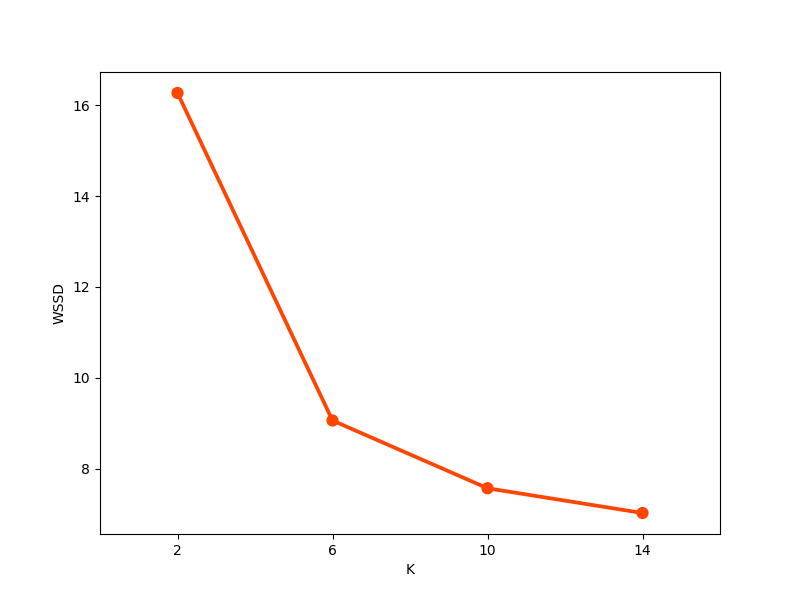

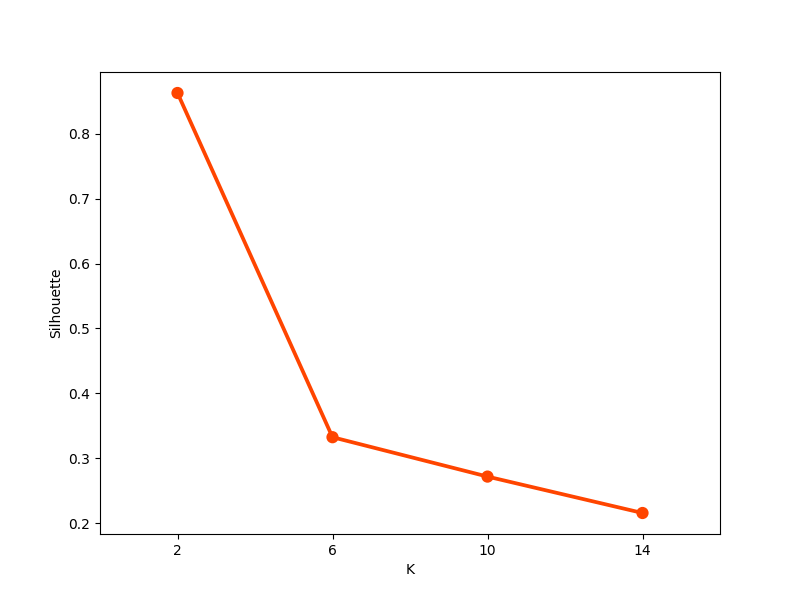

In [22]:
for s in ["20"]:
    plot_clustering_results(clustering_results_dict[s])
    
    

### Evaluating seasons all together

## Dataset composition

In [46]:
# TODO select K according to clustering evaluation
K = [str(k) for k in k_range]
# K = ["2","6"]

### Compute distance between player and centroid of its cluster

In [47]:
compute_distance_from_centroid_UDF = udf(
    lambda player, centroid: float(
        Vectors.squared_distance(
            player, centroid
        )
    ), FloatType()
)

In [48]:
for k in K:
    all_together_df = all_together_df.withColumn(
        "distance_from_centroid" + "_k_" + str(k),
        compute_distance_from_centroid_UDF(
            col("all_vec_min_max"),
            col("centroid" + "_k_" + str(k))
        )
    )
        

### From players to teams

In [49]:
teams_df = all_together_df.groupBy(
    ["season", "club_name", "macro_role"]
).agg(
    { 
        "distance_from_centroid" + "_k_" + str(k): "avg" for k in K 
    }
)

for k in K:
    teams_df = teams_df.withColumnRenamed(
        "avg(distance_from_centroid" + "_k_" + str(k) + ")",
        "avg_distance_from_centroid" + "_k_" + str(k)
    )

In [50]:
def generate_subquery(macro_role, k):
    return f"""(
        case
            when macro_role='{macro_role}' then avg_distance_from_centroid_k_{k} 
        else NULL
        end
    ) as avg_dist_macro_role_{int(macro_role)}_k_{k}
    """

In [51]:
teams_df.createOrReplaceTempView("t")

temp = dict()

for k in K:

    temp[k] = (
        spark.sql(
            f"""
                select season, club_name, {generate_subquery(0.0, k)}, {generate_subquery(1.0, k)}, {generate_subquery(2.0, k)}, {generate_subquery(3.0, k)}, {generate_subquery(4.0, k)}, {generate_subquery(5.0, k)}, {generate_subquery(6.0, k)}, {generate_subquery(7.0, k)}
                from t
            """
        )
        .groupBy("season", "club_name")
        .agg(
            # TODO use for loop as in second cell of "from players to teams"
            sum(f"avg_dist_macro_role_0_k_{k}").alias(f"avg_dist_macro_role_0_k_{k}"),
            sum(f"avg_dist_macro_role_1_k_{k}").alias(f"avg_dist_macro_role_1_k_{k}"),
            sum(f"avg_dist_macro_role_2_k_{k}").alias(f"avg_dist_macro_role_2_k_{k}"),
            sum(f"avg_dist_macro_role_3_k_{k}").alias(f"avg_dist_macro_role_3_k_{k}"),
            sum(f"avg_dist_macro_role_4_k_{k}").alias(f"avg_dist_macro_role_4_k_{k}"),
            sum(f"avg_dist_macro_role_5_k_{k}").alias(f"avg_dist_macro_role_5_k_{k}"),
            sum(f"avg_dist_macro_role_6_k_{k}").alias(f"avg_dist_macro_role_6_k_{k}"),
            sum(f"avg_dist_macro_role_7_k_{k}").alias(f"avg_dist_macro_role_7_k_{k}"),
        )
    )

In [52]:
# NOTE executing this cell n times, w/o restoring teams_df --> 
# n copies of avg_dist_macro_role_[0:7]_k_[2, 6]

teams_df = temp[str(K[0])]

for i in range(1, len(K)):
    teams_df = teams_df.join(
        temp[str(K[i])], on=["season", "club_name"]
    )

In [53]:
avg_distances_dict = dict()
avg_distances_vec_dict = dict()

for k in K:
    
    avg_distances_dict[k] = [
        f"avg_dist_macro_role_{i}_k_{k}" for i in range(0, NUM_MACRO_ROLES)
    ]

    avg_distances_vec_dict[k] = f"avg_dist_vec_k_{k}"

In [54]:
import builtins

global_max = teams_df.select(
    greatest(
        *list(
            itertools.chain.from_iterable(
                avg_distances_dict.values()
            )
        )
    ).alias("row_wise_max")
).collect()

global_max = [row["row_wise_max"] for row in global_max]

global_max = builtins.max(global_max)


In [55]:
teams_df = teams_df.fillna(global_max * 1.5)    

In [56]:
for k in K:

    assembler = VectorAssembler(
        inputCols=avg_distances_dict[k], outputCol=avg_distances_vec_dict[k]
    )

    teams_df = assembler.transform(teams_df)

## Learning from clustering

In [80]:
clustering_learning_df = teams_df

In [81]:
clustering_learning_df.printSchema()

root
 |-- season: string (nullable = true)
 |-- club_name: string (nullable = true)
 |-- avg_dist_macro_role_0_k_2: double (nullable = false)
 |-- avg_dist_macro_role_1_k_2: double (nullable = false)
 |-- avg_dist_macro_role_2_k_2: double (nullable = false)
 |-- avg_dist_macro_role_3_k_2: double (nullable = false)
 |-- avg_dist_macro_role_4_k_2: double (nullable = false)
 |-- avg_dist_macro_role_5_k_2: double (nullable = false)
 |-- avg_dist_macro_role_6_k_2: double (nullable = false)
 |-- avg_dist_macro_role_7_k_2: double (nullable = false)
 |-- avg_dist_macro_role_0_k_6: double (nullable = false)
 |-- avg_dist_macro_role_1_k_6: double (nullable = false)
 |-- avg_dist_macro_role_2_k_6: double (nullable = false)
 |-- avg_dist_macro_role_3_k_6: double (nullable = false)
 |-- avg_dist_macro_role_4_k_6: double (nullable = false)
 |-- avg_dist_macro_role_5_k_6: double (nullable = false)
 |-- avg_dist_macro_role_6_k_6: double (nullable = false)
 |-- avg_dist_macro_role_7_k_6: double (nullab

In [82]:
clustering_learning_df = clustering_learning_df.join(
    df, 
    on=["club_name", "season"]
)

In [83]:
clustering_learning_df.printSchema()

root
 |-- club_name: string (nullable = true)
 |-- season: string (nullable = true)
 |-- avg_dist_macro_role_0_k_2: double (nullable = false)
 |-- avg_dist_macro_role_1_k_2: double (nullable = false)
 |-- avg_dist_macro_role_2_k_2: double (nullable = false)
 |-- avg_dist_macro_role_3_k_2: double (nullable = false)
 |-- avg_dist_macro_role_4_k_2: double (nullable = false)
 |-- avg_dist_macro_role_5_k_2: double (nullable = false)
 |-- avg_dist_macro_role_6_k_2: double (nullable = false)
 |-- avg_dist_macro_role_7_k_2: double (nullable = false)
 |-- avg_dist_macro_role_0_k_6: double (nullable = false)
 |-- avg_dist_macro_role_1_k_6: double (nullable = false)
 |-- avg_dist_macro_role_2_k_6: double (nullable = false)
 |-- avg_dist_macro_role_3_k_6: double (nullable = false)
 |-- avg_dist_macro_role_4_k_6: double (nullable = false)
 |-- avg_dist_macro_role_5_k_6: double (nullable = false)
 |-- avg_dist_macro_role_6_k_6: double (nullable = false)
 |-- avg_dist_macro_role_7_k_6: double (nullab

In [84]:
clustering_learning_df_train_df, clustering_learning_df_test_df = clustering_learning_df.randomSplit(
    # [0.9,0.1]
    # NOTE reactive 90/10 split, keep 70/30 just when using one league
    [0.7,0.3]
)

In [85]:
NUM_FOLDS_CV = 4

### Regression

#### Linear Regression

In [86]:
lr_train_df, lr_test_df = clustering_learning_df_train_df, clustering_learning_df_test_df

In [90]:
lr = LinearRegression(
    # featuresCol="feature_vec_ufs_0.1", 
    labelCol="points"
)

# lr_evaluation_metrics = ["r2", "mse"]
lr_evaluation_metrics = ["r2"]
lr_evaluation_metrics_cv = ["r2"]

lr_param_grid = (
    ParamGridBuilder()
    .addGrid(
        lr.featuresCol,
         ["avg_dist_vec_k_2"]
        # avg_distances_vec_dict
    )
    #TODO add intermediate values: prof uses [0.0, 0.5, 1]
    # .addGrid(lr.elasticNetParam, [0.0, 1])
    #TODO add intermediate values: prof uses [0.0, 0.05, 0.1]
    # .addGrid(lr.regParam, [0.0, 0.1])
    # .addGrid(lr.fitIntercept, [True, False])
    .build()
)

find_best_regressor(
    train_df=lr_train_df, 
    test_df=lr_test_df, 
    regressor=lr,
    regressor_evaluation_metrics=lr_evaluation_metrics,
    cv_evaluation_metrics=lr_evaluation_metrics_cv,
    hyperparams_grid=lr_param_grid
)

***** Evaluating Training Set, (Linear Regression, best model according to metric r2) *****
RMSE: 1.975
R2: 0.990
Adjusted R2: 0.965

*** Test Set, (rf, best model elected by r2) ***


r2: -15.23670127570536
*******************************


#### Decision Tree Regressor

## Clustering-learning cross evaluation

Classic left-right plot, with:
Left Y --> elbow result
Right Y --> accuracy
X axis --> # clusters

# Attempt 4: thinking "Deep", shallow injecting some priors

In [16]:
rp_df = df

## Computing the prior (RP coefficient)

In [17]:
rp_df.select("season", "club_name", "place").createOrReplaceTempView("t")

In [18]:
rp_df = spark.sql(
    f"""
    select t.season, t.club_name,
        avg(
            (
                select sub.place
                where sub.season < t.season and sub.club_name == t.club_name
            )
        ) as rp_coeff
    from t, t as sub
    group by t.season, t.club_name
    order by t.season desc
    """
).fillna(0)

In [19]:
rp_df = rp_df.withColumn("rp_coeff", 21 - col("rp_coeff"))

## Learning

## RP impact

plot showing that the more the weight of the RP coefficient is increased, the more the accuracy ofc goes up